In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : qHz4QdXT 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

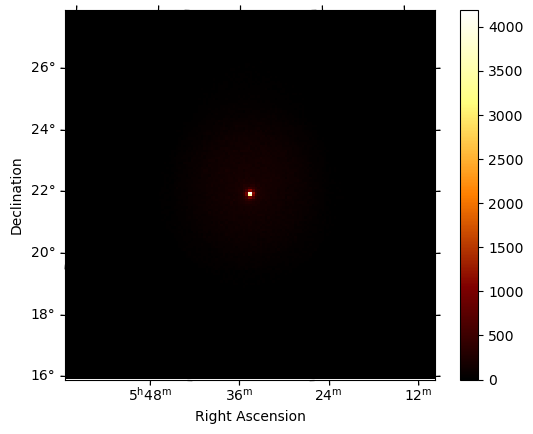

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Amplitude

#### Setting up the amplitude nuisance

In [4]:
shifts_a = np.linspace(0,0.1,6)
shifts_a = np.insert(shifts_a, 0, shifts_a[-2]- shifts_a[-1]) # Standard dataset, but plot on the left this way
shifts_a[1] = 1e-25 # cannot put 0 in it --> 1/ 0 = np.nan
shift = +0.1
labels_xa = ['Standard'] + [str(i) for i in shifts_a[1:]]
labels_xa[1] = str(0)
print(shifts_a)


[-2.e-02  1.e-25  2.e-02  4.e-02  6.e-02  8.e-02  1.e-01]


#### Setting up the index nuisance

In [5]:
delta_shift = 0.08
n = 24
tilt = +delta_shift/n 


tilts_i = np.linspace(0,tilt,5)
tilts_i = np.insert(tilts_i, 0, tilts_i[-2]- tilts_i[-1]) # Standard dataset, but plot on the left this way
tilts_i[1] = 1e-25 # cannot put 0 in it --> 1/ 0 = np.nan

labels_xi = ['Standard'] + [f'{i:.3}' for i in tilts_i[1:]]
labels_xi[1] = str(0)

print(tilts_i)
print(labels_xi)

[-8.33333333e-04  1.00000000e-25  8.33333333e-04  1.66666667e-03
  2.50000000e-03  3.33333333e-03]
['Standard', '0', '0.000833', '0.00167', '0.0025', '0.00333']


In [6]:
sigma_i = tilt 

datasets = []

for j, s_i in enumerate(tilts_i):
    datasets_i = []


    for i, s_a in enumerate(shifts_a):
        sys = sys_dataset(dataset_asimov= dataset_asimov,
                            shift = shift, 
                            tilt = tilt,
                            rnd = False)
        data = sys.create_dataset_N()
        zero = 1e-24
        penalising_covmatrix = [[1/s_i**2, zero], [zero , 1/s_a**2]]
        penalising_invcovmatrix =  penalising_covmatrix
        data.penalising_invcovmatrix = penalising_invcovmatrix
        if i ==0:
            data.models.parameters['amplitude_nuisance'].frozen = True
            data.models.parameters['index_nuisance'].frozen = True

        datasets_i.append(data)     
    datasets.append(datasets_i) 
datasets = np.array(datasets)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [7]:
fitting = True

if fitting:
    
    nui_ampli_all_N  = np.empty_like(datasets)
    nui_ampli_err_all_N  = np.empty_like(datasets)
    nui_index_all_N  = np.empty_like(datasets)
    nui_index_err_all_N  = np.empty_like(datasets)
    index_all_N  = np.empty_like(datasets)
    index_err_all_N  = np.empty_like(datasets)
    amplitude_all_N  = np.empty_like(datasets)
    amplitude_err_all_N  = np.empty_like(datasets)
    stat_all_N  = np.empty_like(datasets)
    
    counts = 0
    for j, s_i in enumerate(tilts_i):
        for i, s_a in enumerate(shifts_a):
            dataset = datasets[j][i]
            print("Fitting dataset number ... ", counts, tilts_i[j], shifts_a[i])

            fit_cor = Fit(store_trace=False)
            result_cor = fit_cor.run(dataset)
            print("Stat sum afer ",  dataset.stat_sum())
            counts +=1 
            
            
            nui_ampli_all_N[j][i] = float(dataset.models.parameters['amplitude_nuisance'].value)
            nui_ampli_err_all_N[j][i] = float(dataset.models.parameters['amplitude_nuisance'].error)
            nui_index_all_N[j][i] = float(dataset.models.parameters['index_nuisance'].value)
            nui_index_err_all_N[j][i] = float(dataset.models.parameters['index_nuisance'].error)
            index_all_N[j][i] = float(dataset.models.parameters['index'].value)
            index_err_all_N[j][i] = float(dataset.models.parameters['index'].error)
            amplitude_all_N[j][i] = float(dataset.models.parameters['amplitude'].value)
            amplitude_err_all_N[j][i] = float(dataset.models.parameters['amplitude'].error)
            stat_all_N[j][i] = float(dataset.stat_sum())
            
                          
    print("saving ... ")    
    with open('data/4_nui_ampli_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_ampli_all_N.tolist(), file)
    with open('data/4_nui_ampli_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_ampli_err_all_N.tolist(), file)
    with open('data/4_nui_index_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_index_all_N.tolist(), file)
    with open('data/4_nui_index_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_index_err_all_N.tolist(), file)
    with open('data/4_index_all_N.yaml', 'w') as file:
        documents = yaml.dump(index_all_N.tolist(), file)
    with open('data/4_index_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(index_err_all_N.tolist(), file)
    with open('data/4_amplitude_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitude_all_N.tolist(), file)
    with open('data/4_amplitude_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitude_err_all_N.tolist(), file)
    with open('data/4_stat_all_N.yaml', 'w') as file:
        documents = yaml.dump(stat_all_N.tolist(), file)

Fitting dataset number ...  0 -0.0008333333333333335 -0.020000000000000004
Stat sum afer  -753580.087167005
Fitting dataset number ...  1 -0.0008333333333333335 1e-25
Stat sum afer  -753580.0871039463
Fitting dataset number ...  2 -0.0008333333333333335 0.02
Stat sum afer  -753580.0870935422
Fitting dataset number ...  3 -0.0008333333333333335 0.04
Stat sum afer  -753580.0876955673
Fitting dataset number ...  4 -0.0008333333333333335 0.06
Stat sum afer  -753580.0886172741
Fitting dataset number ...  5 -0.0008333333333333335 0.08
Stat sum afer  -753580.0887248894
Fitting dataset number ...  6 -0.0008333333333333335 0.1
Stat sum afer  -753580.0881607381
Fitting dataset number ...  7 1e-25 -0.020000000000000004
Stat sum afer  -753580.087167005
Fitting dataset number ...  8 1e-25 1e-25
Stat sum afer  -753580.087167005
Fitting dataset number ...  9 1e-25 0.02
Stat sum afer  -753580.0871032543
Fitting dataset number ...  10 1e-25 0.04
Stat sum afer  -753580.0877114023
Fitting dataset number 

In [8]:
if fitting == False:
    print("reading ... ")    
    with open('data/4_nui_ampli_all_N.yaml') as file:
        nui_ampli_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_nui_ampli_err_all_N.yaml') as file:
        nui_ampli_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_nui_index_all_N.yaml') as file:
        nui_index_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_nui_index_err_all_N.yaml') as file:
        nui_index_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_index_all_N.yaml') as file:
        index_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_index_err_all_N.yaml') as file:
        index_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_amplitude_all_N.yaml') as file:
        amplitude_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_amplitude_err_all_N.yaml') as file:
        amplitude_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_stat_all_N.yaml') as file:
        stat_all_N = yaml.load( file, Loader=yaml.FullLoader)


Text(0.5, 0, 'Penalty Strength on Amplitude Nuisance ')

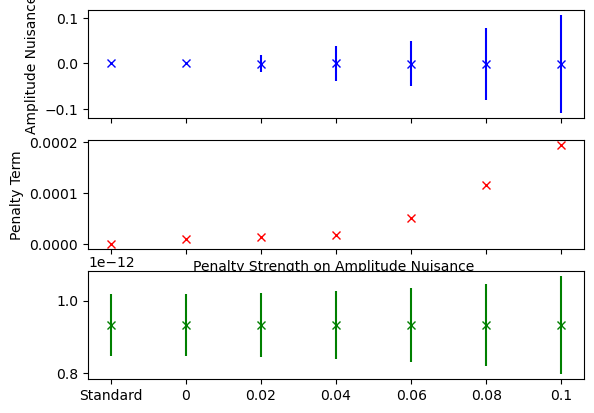

In [9]:
from gammapy.stats.fit_statistics import gaussian_penality
fig , axs = plt.subplots(3,1, sharex=True)
j = -1
for i, d in enumerate(datasets[j]):
    axs[0].errorbar(shifts_a[i], nui_ampli_all_N[j][i],
                    yerr = nui_ampli_err_all_N[j][i], fmt = 'x', color = 'blue')
    pen = nui_ampli_all_N[j][i]**2 / shifts_a[i] ** 2
    pen = gaussian_penality(d.models.parameters.penalised_parameters, 
                            d.penalising_invcovmatrix)
    axs[1].plot(shifts_a[i], pen, 'x', color = 'red')
    
    
    axs[2].errorbar(shifts_a[i], amplitude_all_N[j][i],
                    yerr = amplitude_err_all_N[j][i], fmt = 'x', color = 'green')
    
axs[0].set_xticks(shifts_a,labels_xa)    
axs[1].set_xticks(shifts_a,labels_xa)    
axs[0].set_ylabel("Amplitude Nuisance")
axs[1].set_ylabel("Penalty Term")
axs[1].set_xlabel("Penalty Strength on Amplitude Nuisance ")

0
1
2
3
4
5


Text(0.5, 0, 'Penalty Strength on Index Nuisance ')

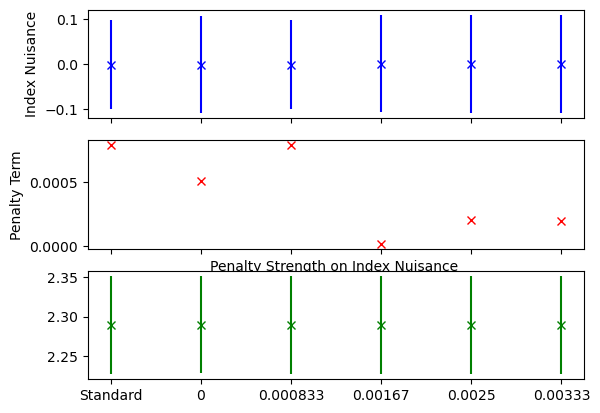

In [10]:
fig , axs = plt.subplots(3,1, sharex=True)
i = -1
for j, d in enumerate(datasets[:,i]):
    print(j)
    axs[0].errorbar(tilts_i[j], nui_ampli_all_N[j][i],
                    yerr = nui_ampli_err_all_N[j][i], fmt = 'x', color = 'blue')
    pen = nui_ampli_all_N[j][i]**2 / tilts_i[j] ** 2
    pen = gaussian_penality(d.models.parameters.penalised_parameters, 
                            d.penalising_invcovmatrix)
    axs[1].plot(tilts_i[j], pen, 'x', color = 'red')
    axs[2].errorbar(tilts_i[j], index_all_N[j][i],
                    yerr = index_err_all_N[j][i], fmt = 'x', color = 'green')
axs[0].set_xticks(tilts_i,labels_xi)    
axs[1].set_xticks(tilts_i,labels_xi)    
axs[0].set_ylabel("Index Nuisance")
axs[1].set_ylabel("Penalty Term")
axs[1].set_xlabel("Penalty Strength on Index Nuisance ")